<a href="https://colab.research.google.com/github/Harshvardhan392/Harshvardhan392/blob/main/NLPJ_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


'''
The dataset consists of 1989 rows of top 25 news(of those days). 
There are both upside and downside closing of DJI in the data whic are denoted by 1 and 0. 
News headlines are of different lengths and are given in sentences. 
Using this dataset, we will train our LSTM model with upside and downside closing status of DJI. 
First, we will make news headlines available for the LSTM model. 
After training our model, we will examine the accuracy and loss values on the chart.
'''


Importing the required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
import keras
import tensorflow as tf

from scipy import stats


from keras.models import Sequential
from keras.layers import Dense, Embedding,LSTM
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.models import load_model
from sklearn.model_selection import train_test_split
import re
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
!pip install transformers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 24.6 MB/s 
     |████████████████████████████████| 182 kB 72.9 MB/s 
     |████████████████████████████████| 7.6 MB 32.3 MB/s 


0       b"Georgia 'downs two Russian warplanes' as cou...
1       b'Why wont America and Nato help us? If they w...
2       b'Remember that adorable 9-year-old who sang a...
3       b' U.S. refuses Israel weapons to attack Iran:...
4       b'All the experts admit that we should legalis...
                              ...                        
1984    Barclays and RBS shares suspended from trading...
1985    2,500 Scientists To Australia: If You Want To ...
1986    Explosion At Airport In Istanbul_Yemeni former...
1987    Jamaica proposes marijuana dispensers for tour...
1988    A 117-year-old woman in Mexico City finally re...
Name: News_headlines, Length: 1989, dtype: object
            Date  Label                                               Top1  \
0     2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1     2008-08-11      1  b'Why wont America and Nato help us? If they w...   
2     2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   


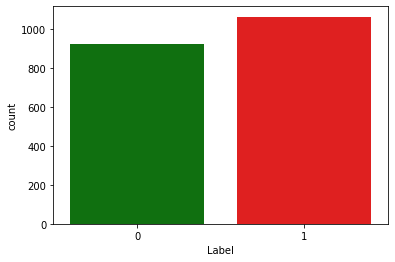

1    1065
0     924
Name: Label, dtype: int64


In [2]:
data1 = pd.read_csv("Combined_News_DJIA.csv")
data = pd.DataFrame(data1)
data['News_headlines'] = data[['Top1','Top2','Top3','Top4','Top5','Top6','Top7','Top8','Top9','Top10','Top11','Top12','Top13','Top14','Top15','Top16','Top17','Top18','Top19','Top20','Top21']].apply(lambda x: '_'.join(x), axis=1)
print(data.News_headlines)
data['Quarters_length'] = data['News_headlines'].apply(len)
print (data)
print(data.head())
# we are looking at the size of our data.
data.shape
data.info()
#we see that there is no null value in our data
# statistical summary of our data
data.describe()
sns.countplot(data["Label"], palette = ["green","red"])
plt.show()
print(data.Label.value_counts())

Generating word frequencies

In [3]:
#First we generate a frequency table of all the words present in all the reviews combined.
def gen_freq(text):
    #will store all the words in list
    words_list = []
    
    #Loop over all the words and extract word from list
    for word in text.split():
        words_list.extend(word)
        
    #Generate word frequencies using value counts in word_list
    word_freq = pd.Series(words_list).value_counts()
    
    #print top 100 words
    word_freq[:100]
    
    return word_freq    



freq = gen_freq(data.News_headlines.str)
freq

the                      23260
to                       21838
of                       19349
in                       18363
a                        12090
                         ...  
Economically_Gadhafi,        1
Entitlements                 1
criticism."                  1
mavericks                    1
Duterte                      1
Length: 106743, dtype: int64

**Creating Word clouds**

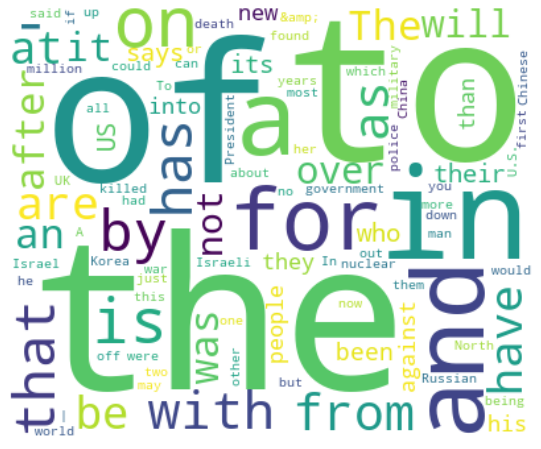

In [4]:
#Word cloud using word frequencies
#Import library WordCloud
from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

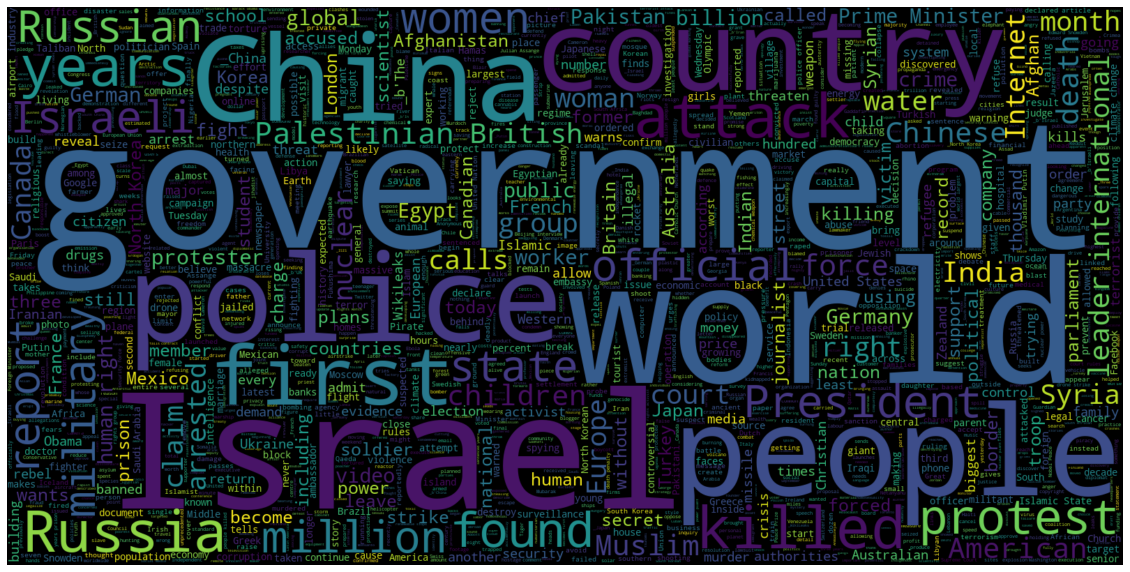

In [5]:
#Word cloud using Upside closing
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.Label == 1].News_headlines))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

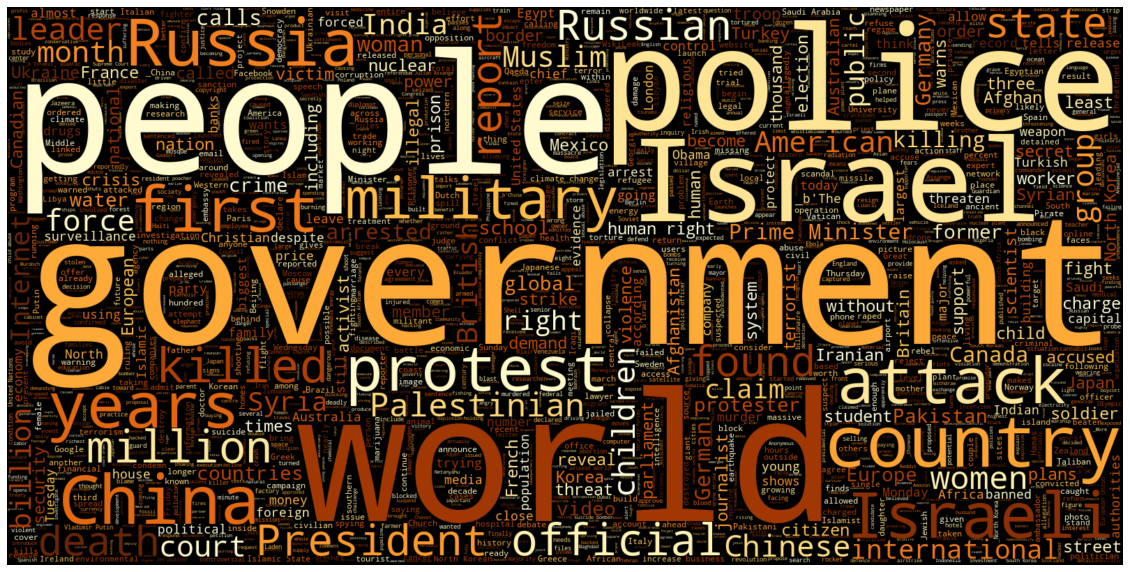

In [6]:
#Word cloud using Downside closing
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.Label == 0].News_headlines))

plt.axis("off")
plt.imshow(Wc , interpolation = 'bilinear')

**Removing Stopwords**

In [7]:
from nltk.corpus import stopwords
stop_word_list = stopwords.words('english')


from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

#Tokenization of text
tokenizer=ToktokTokenizer()

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_word_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_word_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on news headline coloumn
data['News_headlines']= data['News_headlines'].apply(remove_stopwords)

**Text Cleaning**

'''process of clearing punctuation marks in data.
cleaning unnecessary marks in data.
capitalization to lowercase.
cleaning extra spaces.
removal of stopwords in sentences.'''

In [8]:
import re
#clearing punctuation & unnecessary marks
data['News_headlines'] = data['News_headlines'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
data['News_headlines'] = data['News_headlines'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
data['News_headlines'] = data['News_headlines'].apply(lambda x: x.lower())

#cleaning extra spaces
data['News_headlines'] = data['News_headlines'].apply(lambda x: x.strip())

**Removing html strips and noise text**

In [9]:
from bs4 import BeautifulSoup

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    return text

#Apply function on review column
    text = strip_html(text)
    text = remove_between_square_brackets(text)
data['News_headlines']=data['News_headlines'].apply(denoise_text)

data_copy = data.copy()

**Generating Word clouds after text cleaning :**

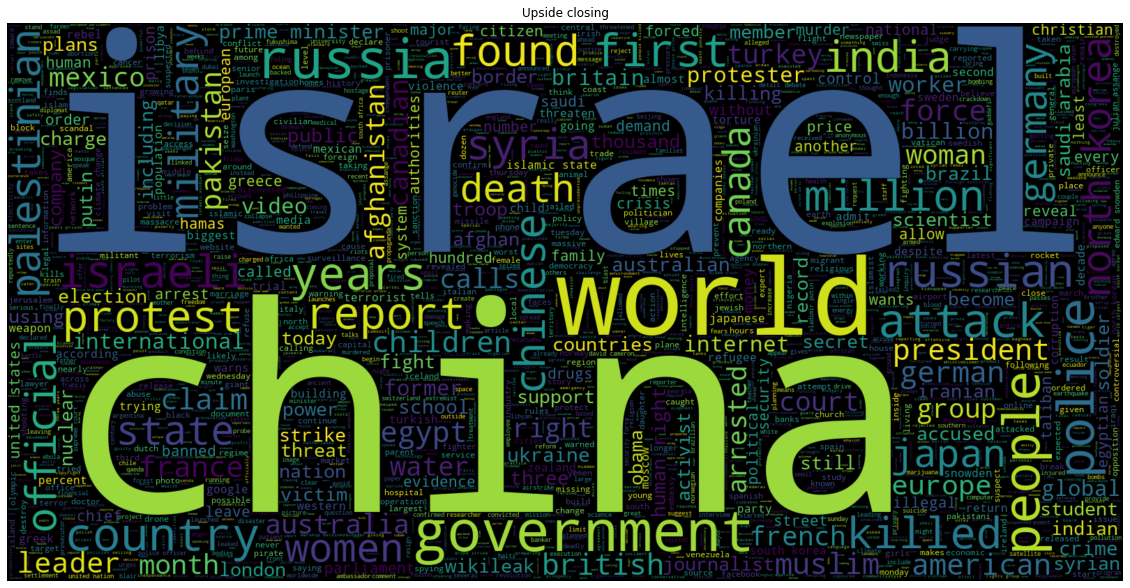

In [10]:
# UPSIDE CLOSING
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,
               min_word_length=5).generate(" ".join(data[data.Label == 1].News_headlines))

plt.axis("off")
plt.title('Upside closing')
plt.imshow(Wc , interpolation = 'bilinear')

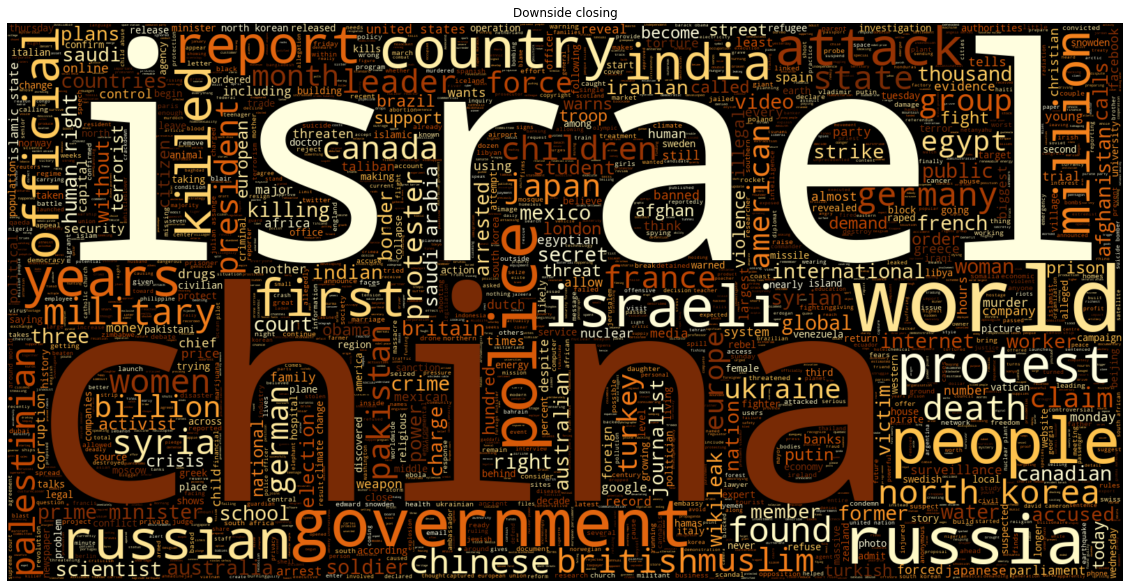

In [11]:
# DOWNSIDE CLOSING
plt.figure(figsize = (20,20))
Wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,colormap="YlOrBr",
               min_word_length=5).generate(" ".join(data[data.Label == 0].News_headlines))

plt.axis("off")
plt.title('Downside closing')
plt.imshow(Wc , interpolation = 'bilinear')

**Train - Test Split**

In [12]:
sentiment = data['Label'].values
sentiment

data = data['News_headlines']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.1, random_state = 42)

**Creating a Dictionary**
"""We create a dictionary of 15000 most used words in English for later use."""

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 15000)
tokenizer.fit_on_texts(data)
#tokenizer.word_index

In [14]:
#Bring the Headlines to the same size
#Headlines of different lengths cannot train the model. That's why we need to make the sentences the same size.

x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

#We can replace the words in our sentences with whichever index they are included in the dictionary we have created above.
#Then we take the word count of each of our sentences in our data and create a list.
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)


#Here, when setting the number of tokens, a number is determined by taking into account the variability around the average.
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

#max_tokens : This value will allow us to reduce the distribution of sentences in our data and the sentences with opposite lengths, if any, to the average.

315

In [15]:
#It is checked what percentage of the data this determined number covers.
np.sum(num_tokens < max_tokens) / len(num_tokens)

#data is adjusted according to the number of tokens specified
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_tokens, maxlen=max_tokens)

x_train_pad.shape

idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

#We write a function to revert the sentences that we have made int.


#normal headline
print(return_to_sentence(x_train_pad[9]))

#token equivalent of headline
print(x_train_pad[9])

boris johnson george w bush cant fight freedom torture wests aim spread rule law cannot achieved vile means taliban commander al qa ida fighters afghanistan more fought south east well here seven years operations seen single al qa ida fighter one settlers torch west bank olive trees israeli settlers torched hundreds palestinian olive trees occupied west bank another sign extremists targeting key product palestinian economy likely killed children cannot afford her one many old parents southern indian state dying way one blinks ritual murders ireland young flee abroad economic meltdown looms two year old girl suffering leukemia died waiting urgent referral israeli hospital since january total patients died waiting access hospitals outside gaza police egypt accused beating teenager death dumping body canal hong kong officially world city generating least m tonnes rubbish last year netanyahu presents security cabinet clinton incentive f fighter planes security guarantees exchange day west 

**"""LSTM Model"""**

In [16]:
model1 = Sequential()

embedding_size = 50

model1.add(Embedding(input_dim=15000,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))

model1.add(LSTM(units=16, return_sequences=True))
model1.add(Dropout(0.1))

model1.add(LSTM(units=8, return_sequences=True))
model1.add(Dropout(0.1))

model1.add(LSTM(units=4))
model1.add(Dropout(0.1))

model1.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3) 

model1.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model1.summary()

history = model1.fit(x_train_pad, y_train, validation_split=0.3, epochs=5, batch_size=1000, shuffle=True, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 315, 50)          750000    
                                                                 
 lstm (LSTM)                 (None, 315, 16)           4288      
                                                                 
 dropout (Dropout)           (None, 315, 16)           0         
                                                                 
 lstm_1 (LSTM)               (None, 315, 8)            800       
                                                                 
 dropout_1 (Dropout)         (None, 315, 8)            0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0

**RESULT**

In [17]:
result = model1.evaluate(x_test_pad, y_test)

7/7 [==============================] - 0s 15ms/step - loss: 0.6896 - accuracy: 0.5628


**"""Visualization of Accuracy & Loss"""**

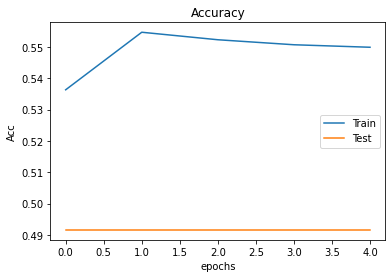

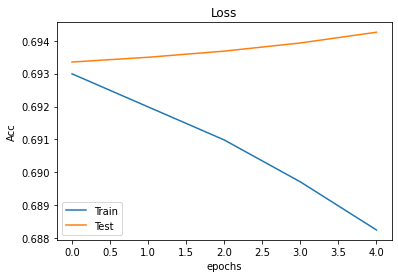

In [18]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()




plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

For random sample testing using LSTM mmodel

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 315
# Headlines on which we need to predict
sentence = ["syria president surrenders to US army"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model1.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 [==============================] - 1s 959ms/step
syria president surrenders to US army
Predicted sentiment :  Positive


BERT

In [20]:
train, test= train_test_split(data_copy, test_size=0.1, random_state=42)
Xtrain, ytrain = train['News_headlines'], train['Label']
Xtest, ytest = test['News_headlines'], test['Label']
#splitting the train set into train and validation
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,test_size=0.2,random_state=10)


In [21]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tk = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tk.fit_on_texts(Xtrain)
word_index = tk.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  27016


In [22]:
##create sequences of reviews
seq_train = tk.texts_to_sequences(Xtrain)
seq_test =  tk.texts_to_sequences(Xtest)

In [23]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 427


In [24]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 329


In [25]:
import transformers
#Perform tokenization
# automatically download the vocab used during pretraining or fine-tuning a given model,use from_pretrained() method
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [26]:
#pass our texts to the tokenizer. 
Xtrain_enc = tokenizer(Xtrain.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np')#return numpy object
Xval_enc = tokenizer(Xval.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np')#return numpy object
Xtest_enc = tokenizer(Xtest.tolist(), max_length=max_seq_len, 
                         truncation=True, padding='max_length', 
                         add_special_tokens=True, return_tensors='np') #return numpy object

In [27]:
import tensorflow as tf
#preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    ytrain
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    yval
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    ytest
))

In [28]:
# creating BERT Model
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D
from tensorflow.keras.models import Model
def bert_model(train_dataset,val_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,
                  validation_data = val_dataset.batch(32),epochs = epochs)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(train_dataset.batch(32)))
    print("Validation score:", model.evaluate(val_dataset.batch(32)))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [29]:
transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [30]:
epochs = 3
max_len = max_seq_len
r,model,n_epochs = bert_model(train_dataset,val_dataset,transformer,max_len,epochs)

----Building the model----
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 329)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 329)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 329, 768),                                                   
                                 hidden_states=None                

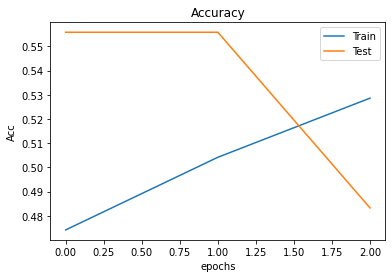

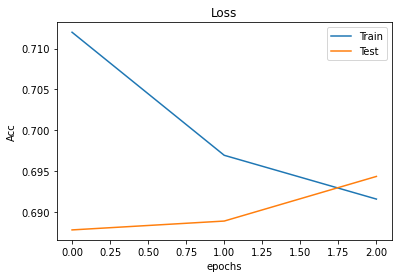

In [31]:
plt.figure()
plt.plot(r.history["accuracy"], label = "Train")
plt.plot(r.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()




plt.figure()
plt.plot(r.history["loss"], label = "Train")
plt.plot(r.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()